In [2]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
from collections import Counter
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

from adjustText import adjust_text

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.op.analysis import Run_Manager

from sklearn.decomposition import PCA
import sklearn.datasets

from sae_src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph

In [3]:
save_figure_kwargs = dict(
    root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\supplement',
    exts = ['png', 'pdf'],
)

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.cut = 'eval'
info.cut = 'final'

info.device = 'cuda'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {n:f'C{n}' for n in range(10)}
# info.group_names = {0:'Baseline', 1: 'Structural', 2:'Ladder', 3:'Ada-IN', }

preset_figure_info(info)
print(info)

t{fsize, cut, device, results_name, small_font_size, medium_font_size, large_font_size, colors}


In [4]:
raw = '''Copy of AE	3ds_ae0_e-c12_d-c12_mish_210125-050038
AE seed 2	3ds_ae_e-c12_d-c12_mish-seed2_210131-230456
AE seed 3	3ds_ae_e-c12_d-c12_mish-seed3_210131-230456
AE seed 4	3ds_ae_e-c12_d-c12_mish-seed4_210131-230456
AE seed 5	3ds_ae_e-c12_d-c12_mish-seed5_210131-230456
Copy of VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254
VAE1 seed 2	3ds_vae1_e-c12_d-c12_mish-seed2_210131-230457
VAE1 seed 3	3ds_vae1_e-c12_d-c12_mish-seed3_210131-230501
VAE1 seed 4	3ds_vae1_e-c12_d-c12_mish-seed4_210131-230501
VAE1 seed 5	3ds_vae1_e-c12_d-c12_mish-seed5_210131-230500
Copy of VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255
VAE2 seed 2	3ds_vae2_e-c12_d-c12_mish-seed2_210131-230501
VAE2 seed 3	3ds_vae2_e-c12_d-c12_mish-seed3_210131-230459
VAE2 seed 4	3ds_vae2_e-c12_d-c12_mish-seed4_210131-230503
VAE2 seed 5	3ds_vae2_e-c12_d-c12_mish-seed5_210131-230501
Copy of WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253
WAE10 seed 2	3ds_wae10_e-c12_d-c12_mish-seed2_210201-021010
WAE10 seed 3	3ds_wae10_e-c12_d-c12_mish-seed3_210201-021013
WAE10 seed 4	3ds_wae10_e-c12_d-c12_mish-seed4_210201-021011
WAE10 seed 5	3ds_wae10_e-c12_d-c12_mish-seed5_210201-021840
Copy of WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143
WAE100 seed 2	3ds_wae100_e-c12_d-c12_mish-seed2_210131-230501
WAE100 seed 3	3ds_wae100_e-c12_d-c12_mish-seed3_210131-230503
WAE100 seed 4	3ds_wae100_e-c12_d-c12_mish-seed4_210131-230503
WAE100 seed 5	3ds_wae100_e-c12_d-c12_mish-seed5_210131-230503
Copy of AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253
AE S4 seed 2	3ds_ae_e-c12_d-s4_mish-seed2_210131-230504
AE S4 seed 3	3ds_ae_e-c12_d-s4_mish-seed3_210131-230506
AE S4 seed 4	3ds_ae_e-c12_d-s4_mish-seed4_210131-230506
AE S4 seed 5	3ds_ae_e-c12_d-s4_mish-seed5_210131-230505
Copy of AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253
AE S6 seed 2	3ds_ae_e-c12_d-s6_mish-seed2_210131-230505
AE S6 seed 3	3ds_ae_e-c12_d-s6_mish-seed3_210131-230503
AE S6 seed 4	3ds_ae_e-c12_d-s6_mish-seed4_210131-230505
AE S6 seed 5	3ds_ae_e-c12_d-s6_mish-seed5_210131-230504
Copy of AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335
AE S12 seed 2	3ds_ae_e-c12_d-s12_mish-seed6_210201-035456
AE S12 seed 3	3ds_ae_e-c12_d-s12_mish-seed2_210131-150235
AE S12 seed 4	3ds_ae_e-c12_d-s12_mish-seed5_210131-150235
AE S12 seed 5	3ds_ae_e-c12_d-s12_mish-seed8_210201-035456
Copy of AE S12 nosplit	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236
AE S12 nosplit seed 2	3ds_ae_e-c12_d-s12_nosplit-mish-seed3_210131-230502
AE S12 nosplit seed 3	3ds_ae_e-c12_d-s12_nosplit-mish-seed5_210131-230503
AE S12 nosplit seed 4	3ds_ae_e-c12_d-s12_nosplit-mish-seed4_210131-230506
AE S12 nosplit seed 5	3ds_ae_e-c12_d-s12_mish-nosplit-seed7_210201-035456
Copy of VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249
VAE1 L12 seed 2	3ds_vae1_e-l12_d-l12_mish-seed2_210131-230506
VAE1 L12 seed 3	3ds_vae1_e-l12_d-l12_mish-seed3_210131-230505
VAE1 L12 seed 4	3ds_vae1_e-l12_d-l12_mish-seed4_210131-230507
VAE1 L12 seed 5	3ds_vae1_e-l12_d-l12_mish-seed5_210131-230507'''

def _fix(title, *other, num=None):
    
    title = title.replace('Copy of ', '')
    if num is None:
        if 'seed' in title:
            num = title[-1]
            title = title[:-7]
        else:
            num = 1
    title = title + f' ({num})'
    if len(other):
        return [title, *other]
    return title

def _unfix(title):
    if '(' in title:
        return title.split(' (')[0]

model_tbl = [_fix(*row.split('\t')) for row in raw.split('\n')]
headers = ['Ident', '3D-Shapes']
dataset_names = headers[1:]
all_model_names = {ds:{} for ds in dataset_names}
for title, *names in model_tbl:
    for path, ds in zip(names, dataset_names):
        if path is not None and len(path):
            all_model_names[ds][title] = path
print(tabulate(model_tbl, headers=headers))
len(model_tbl)

Ident               3D-Shapes
------------------  ---------------------------------------------------
AE (1)              3ds_ae0_e-c12_d-c12_mish_210125-050038
AE (2)              3ds_ae_e-c12_d-c12_mish-seed2_210131-230456
AE (3)              3ds_ae_e-c12_d-c12_mish-seed3_210131-230456
AE (4)              3ds_ae_e-c12_d-c12_mish-seed4_210131-230456
AE (5)              3ds_ae_e-c12_d-c12_mish-seed5_210131-230456
VAE1 (1)            3ds_vae1_e-c12_d-c12_mish_210125-140254
VAE1 (2)            3ds_vae1_e-c12_d-c12_mish-seed2_210131-230457
VAE1 (3)            3ds_vae1_e-c12_d-c12_mish-seed3_210131-230501
VAE1 (4)            3ds_vae1_e-c12_d-c12_mish-seed4_210131-230501
VAE1 (5)            3ds_vae1_e-c12_d-c12_mish-seed5_210131-230500
VAE2 (1)            3ds_vae2_e-c12_d-c12_mish_210125-140255
VAE2 (2)            3ds_vae2_e-c12_d-c12_mish-seed2_210131-230501
VAE2 (3)            3ds_vae2_e-c12_d-c12_mish-seed3_210131-230459
VAE2 (4)            3ds_vae2_e-c12_d-c12_mish-seed4_210131-230503
V

50

In [5]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\final')
device = 'cuda'

In [6]:
base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'$\beta$VAE', 'WAE10':'WAE1', 'WAE100':'WAE2', 'AE S12':'SAE-12', 'AE S4':'SAE-4', 'AE S6': 'SAE-6', 'VAE1 L12':'VLAE-12', 'AE S12 nosplit':'AdaAE-12',
              }
title_order = ['AE S12', 'AE S6', 'AE S4', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10']

title_order = ['AE S12', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10']
mytitles = {}

In [7]:
ds = '3D-Shapes'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, 'VAE2 (2)': None, 'VAE2 (4)': None, 'VAE1 (2)': None }
mytitles['AE S6'] = None
mytitles['AE S4'] = None

In [8]:
groups_idxs = {'AE':1, 'VAE1':5, 'VAE2':6, 'WAE10':8, 'WAE100': 7, 
          'AE S12':0, 'AE S4':4, 'AE S6':9, 'VAE1 L12':3, 'AE S12 nosplit':2}

titles = base_titles.copy()
titles.update(mytitles)

info.group_names = {v:titles.get(k, k) for k,v in groups_idxs.items()}

info.title = ds
model_names = {k:v for k,v in all_model_names[ds].items() if titles[_unfix(k)] is not None}

sample_count = Counter(map(_unfix, [row for row in model_names.keys()]))

for typ, num in sample_count.items():
    if typ in titles:
        for n in range(1,num+1):
            key = _fix(typ, num=n)
            if key not in titles:
                titles[key] = f'{titles[typ]} {n}'
#             titles[_fix(typ, num=n)] = ''
        del titles[typ]

model_names = {k:v for k,v in model_names.items() if titles[k] is not None}
sample_count = Counter(map(_unfix, [row for row in model_names.keys()]))
    
len(model_names), model_names.keys()

(32,
 dict_keys(['AE (1)', 'AE (2)', 'AE (3)', 'AE (4)', 'AE (5)', 'VAE1 (1)', 'VAE1 (3)', 'VAE1 (4)', 'VAE1 (5)', 'VAE2 (1)', 'VAE2 (3)', 'VAE2 (5)', 'WAE10 (1)', 'WAE10 (2)', 'WAE10 (3)', 'WAE10 (4)', 'WAE10 (5)', 'AE S12 (1)', 'AE S12 (2)', 'AE S12 (3)', 'AE S12 (4)', 'AE S12 (5)', 'AE S12 nosplit (1)', 'AE S12 nosplit (2)', 'AE S12 nosplit (3)', 'AE S12 nosplit (4)', 'AE S12 nosplit (5)', 'VAE1 L12 (1)', 'VAE1 L12 (2)', 'VAE1 L12 (3)', 'VAE1 L12 (4)', 'VAE1 L12 (5)']))

In [9]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)

  0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
runs.map(lambda run: run.get_records())
runs.load_results('metrics');
runs.load_results(info.cut);

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups_idxs[_unfix(run.ident)]
    run.title = titles[run.ident]
runs.map(_load_info);

  0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
run = runs[0]

In [13]:
met = run.get_results('metrics')
met.keys()

dict_keys(['scores', 'results'])

In [14]:
for m, k in met['results'].items():
    print(m, '  ', k.keys())

IRS    dict_keys(['disentanglement_scores', 'parents', 'IRS_matrix', 'max_deviations'])
Fairness    dict_keys(['mean_fairness:mean_pred:mean_sens'])
UnsupervisedMetrics    dict_keys(['covariance_matrix', 'mutual_info_score'])
ModularityExplicitness    dict_keys([])
SAP    dict_keys(['SAP_matrix'])
MIG    dict_keys(['entropy'])
DCI    dict_keys(['importance_matrix'])
LatentResponses    dict_keys(['response_mat', 'covariance', 'factor_responses', 'factor_responses_q'])


In [15]:
def _load_fid(run):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    e = run.get_results(info.cut)
    if 'rec_fid' in e:
        run.stats['rec_fid'] = e['rec_fid']
    if 'hybrid_fid' in e:
        run.stats['hybrid_fid'] = e['hybrid_fid']
    if 'prior_fid' in e:
        run.stats['prior_fid'] = e['prior_fid']
    
    met = run.get_results('metrics')
    
    run.stats['IRS'] = met['scores']['IRS']['avg_score']
    run.stats['DCI'] = met['scores']['DCI']['disentanglement']
    run.stats['SAP'] = met['scores']['SAP']['SAP_score']
    run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
    run.stats['ModExp'] = met['scores']['ModularityExplicitness']['modularity_score']
    run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
    run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']
    
    if not hasattr(run, 'data'):
        run.data = util.adict()
    run.data['IRS'] = met['results']['IRS']['IRS_matrix']
    run.data['cov'] = met['results']['UnsupervisedMetrics']['covariance_matrix']
    run.data['SAP'] = met['results']['SAP']['SAP_matrix']
    run.data['DCI'] = met['results']['DCI']['importance_matrix']
    run.data['Response'] = met['results']['LatentResponses']['response_mat']
    run.data['FactorResponse'] = met['results']['LatentResponses']['factor_responses']
    
runs.map(_load_fid);

  0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
centers = {}
for r in runs:
    g = r.group
    if g not in centers:
        centers[g] = []
    centers[g].append([r.stats.rec_loss, r.stats.rec_fid])
for g, c in centers.items():
    centers[g] = np.array(c).mean(0)

<IPython.core.display.Javascript object>


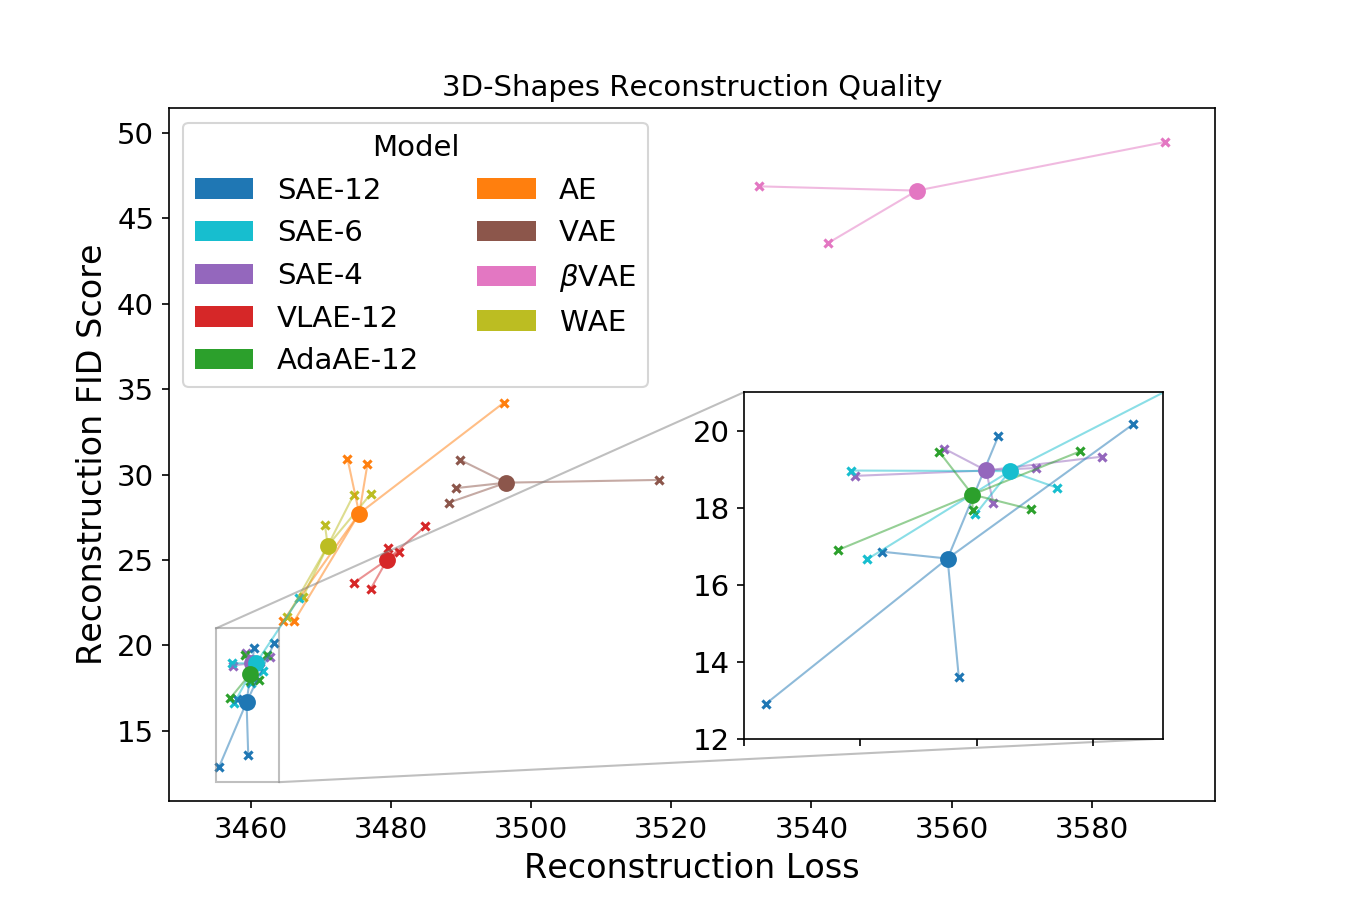

Figure seeds-rec saved as {'pdf', 'png'}


In [21]:
fig, ax = plt.subplots(figsize=info.fsize)


x1, x2, y1, y2 = 3455, 3464, 12, 21
eps = 0.05
axins = ax.inset_axes([0.55, eps+0.04, 0.45-eps, 0.5])
# axins.imshow(Z2, extent=extent, interpolation="nearest",
#           origin="lower")
# for child in ax.get_children():
#     axins.add_artist(child)
# sub region of the original image

for g, c in centers.items():
    plt.scatter(*c, color=info.colors[g], s=50, zorder=3)
    axins.scatter(*c, color=info.colors[g], s=50, zorder=3)

objs = []
texts = []
tps = set()



# axes = [ax, axins]

for r in runs:
#         plt.sca(a)
    cx, cy = centers[r.group]
    x, y = r.stats.rec_loss, r.stats.rec_fid

#     arrowprops = dict(  # arrowstyle='simple',
#         arrowstyle='wedge',
#         # color=sup_color,
#         capstyle='round',
#         # linewidth=10, mutation_scale=150,
#         linewidth=0,  # headwidth=arrow_head,
#         facecolor=info.colors[r.group], edgecolor=None,

#              alpha=0.3,
# #         connectionstyle="arc3,rad=0.2",
#     )
#     plt.annotate('', xytext=(cx, cy), xy=(x, y),
#                  # xycoords='data',
#                  # textcoords='data',
#                  # lw=2,
#     #                  zorder=7,

#                  arrowprops=arrowprops)

    ax.plot([cx, x], [cy, y], ls='-', marker='', color=info.colors[r.group], lw=1, alpha=0.5)
    ax.scatter(x, y, color=info.colors[r.group], marker='x', zorder=2, s=15)


    axins.plot([cx, x], [cy, y], ls='-', marker='', color=info.colors[r.group], lw=1, alpha=0.5)
    axins.scatter(x, y, color=info.colors[r.group], marker='x', zorder=2, s=15)

#     texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.title, horizontalalignment='center',
#       verticalalignment='center',))
    tps.add(r.group)
#     break

# plt.sca(ax)
    
legend_elements = [Patch(facecolor=info.colors[groups[name]], label=info.group_names[groups[name]]) for name in title_order if groups[name] in tps]
plt.legend(handles=legend_elements, title='Model', ncol=2, loc=2)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')


axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
# axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)

util.save_figure('seeds-rec', **save_figure_kwargs)
pass


In [17]:
scores = []
groups = []
typs = []
names = []

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else 'oo') for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

49

<IPython.core.display.Javascript object>


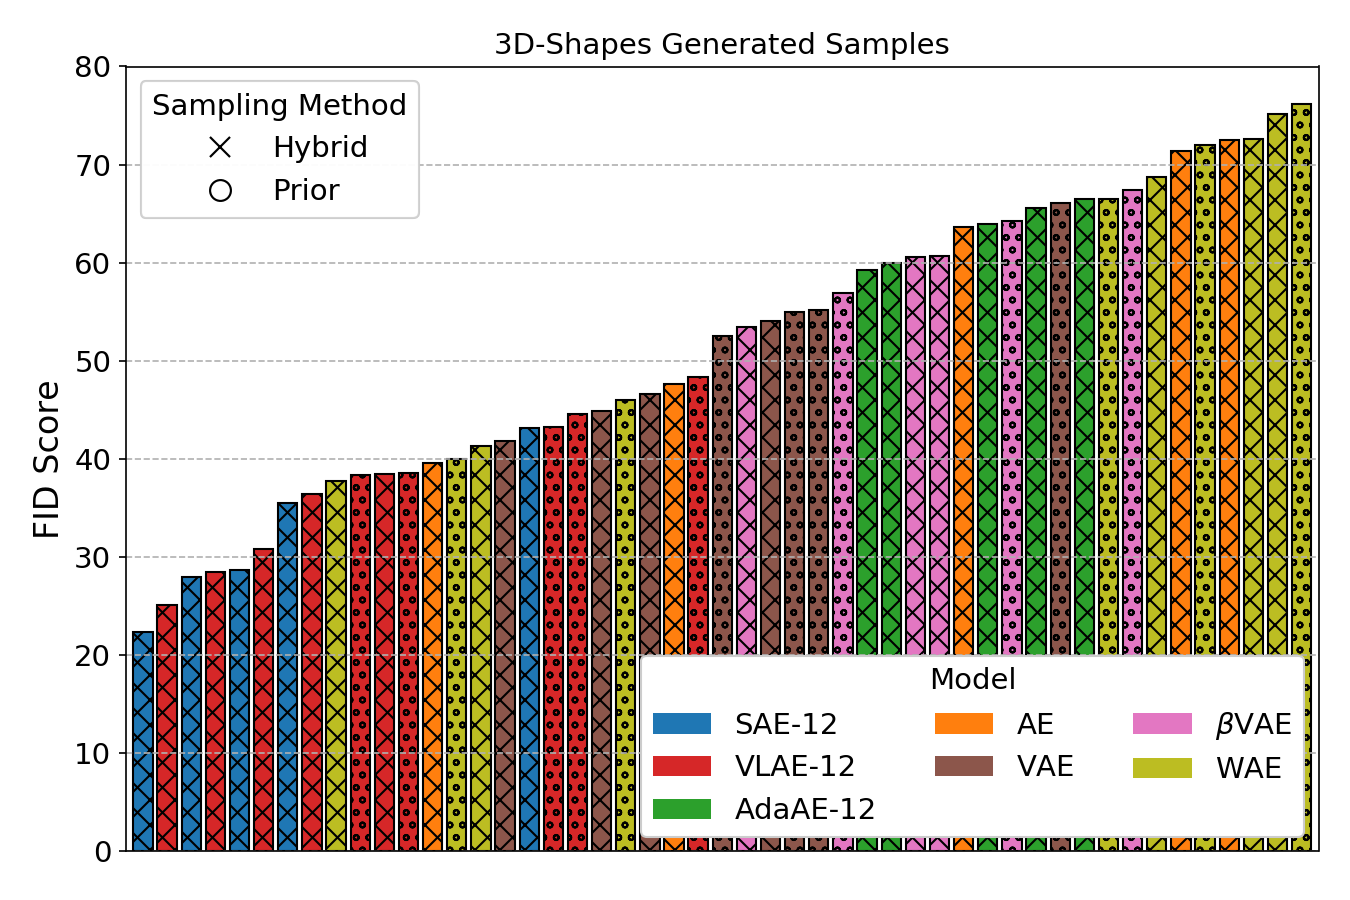

Figure seeds-generated saved as {'png', 'pdf'}


In [20]:
fig, ax = plt.subplots(figsize=info.fsize)
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
plt.xticks([])

legend_elements = [Patch(facecolor=info.colors[groups_idxs[name]], label=info.group_names[groups_idxs[name]]) 
                   for name in title_order]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Hybrid'), 
                    mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
                          markersize=10, label='Prior')]
legend = plt.legend(handles=legend_elements, loc=4, title='Model', ncol=3, framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
else:
    plt.ylim(0,80)
plt.xlim(0-0.7, len(names)-0.3)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=2, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
util.save_figure('seeds-generated', **save_figure_kwargs)
pass

In [12]:
run.results[info.cut].keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [53]:
models = {}

for r in runs:
    
    g = r.group
    
    if g not in models:
        models[g] = {}
    
    stats = models[g]
    
    for stat, val in r.stats.items():
        if stat not in stats:
            stats[stat] = []
        stats[stat].append(val)

In [54]:
pick = 'Response'
# names = title_order.copy()
# keys = [info.group_names[groups[name]] for name in names]

<IPython.core.display.Javascript object>


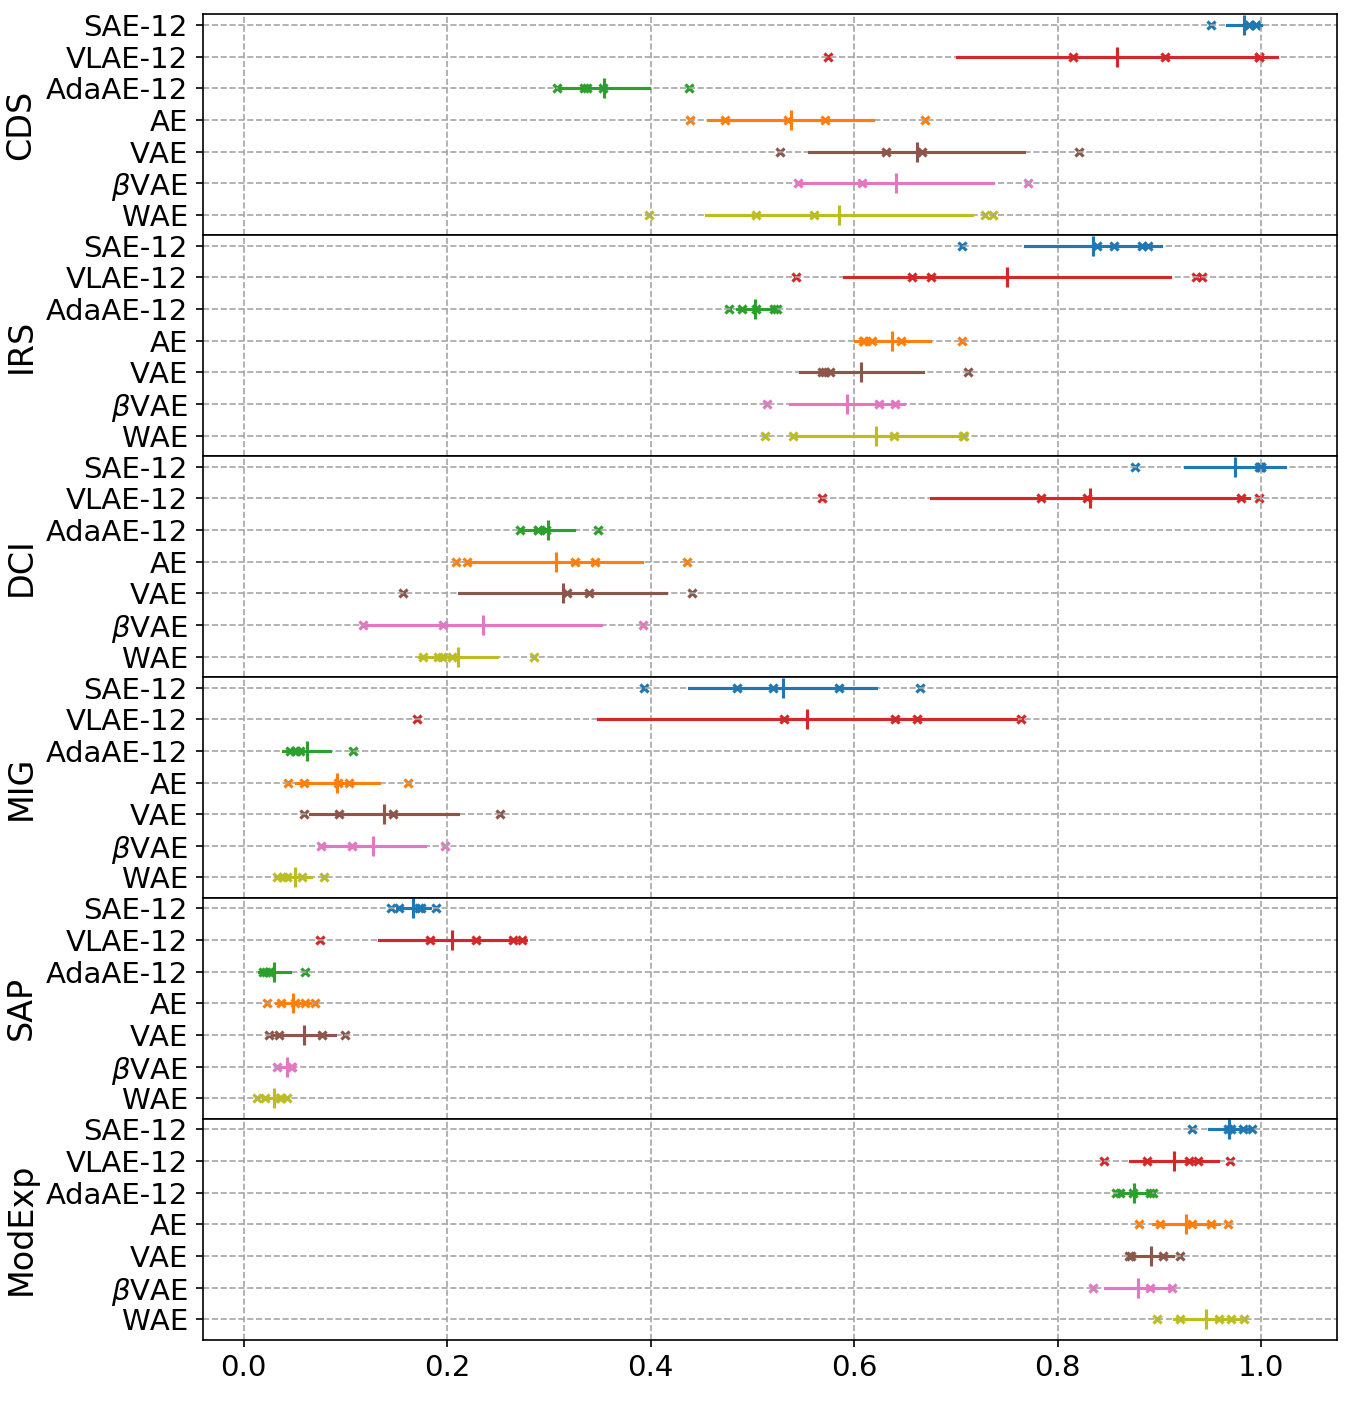

Figure seeds-metrics-main saved as {'pdf', 'png'}


In [59]:
picks = ['Response', 'IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
# picks = ['Response', 'DCI', 'IRS', ]
pick_titles = {'Response': 'CDS', }

fig, axes = plt.subplots(len(picks), figsize=(9,1.5*len(picks) + 0.5), sharex=True)

for pick, ax in zip(picks, axes):
    plt.sca(ax)
    plt.gca().invert_yaxis()
    keys = []
    for i, name in enumerate(title_order):

        g = groups_idxs[name]
        model = models[g]

        vals = np.array(model[pick])
        
        if pick == 'Response':
            vals -= 1/6
            vals /= 5/6

        plt.scatter(vals, [i]*len(vals), c=info.colors[g], marker='x', s=15);

        mu, sigma = np.mean(vals), np.std(vals)

        plt.plot([mu-sigma, mu+sigma], [i,i], c=info.colors[g], ls='-', marker='');
        plt.scatter([mu], [i], c=info.colors[g], marker='|', s=100);
        keys.append(info.group_names[g])
        title = pick_titles.get(pick, pick)
#         plt.title(pick)
        plt.ylabel(title)
    plt.yticks(np.arange(len(keys)), keys)
#     if pick != picks[-1]:
#         plt.xticks([])
# plt.tight_layout()
    plt.grid(which='major', color='0.65', linestyle='--', axis='both')
plt.subplots_adjust(hspace=0.00, bottom=0.06, top=0.99, left=0.15, right=0.99)
util.save_figure('seeds-metrics-main', **save_figure_kwargs)
pass

In [23]:
seeds = {}
for r in runs:
    
    if r.group not in seeds:
        seeds[r.group] = []
    
    seeds[r.group].append(r)
len(seeds)

9

In [24]:
idx = 0

In [25]:
run.data.keys()

odict_keys(['IRS', 'cov', 'SAP', 'DCI', 'Response', 'FactorResponse'])

In [63]:
allRs = {k:torch.stack([r.data['FactorResponse'].min(1)[0].max(-1)[0] for r in seeds[g]]) for k,g in groups.items() if g in seeds}
allMs = {k:torch.stack([r.data['Response'] for r in seeds[g]]) for k,g in groups.items() if g in seeds}
allRs.keys()

dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S12', 'AE S4', 'AE S6', 'VAE1 L12', 'AE S12 nosplit'])

In [195]:
model = 'AE S12'
# model = 'AE S6'
# model = 'AE S4'
# model = 'AE'

g = groups[model]

In [196]:
irs = [r.data['IRS'] for r in seeds[g]]
sap = [r.data['SAP'] for r in seeds[g]]
dci = [r.data['DCI'].T for r in seeds[g]]
Rs = allRs[model]
Ms = allMs[model]

In [197]:
avg_title_order = title_order.copy()
avg_title_order = ['AE S12', 'VAE1 L12', 'AE S6', 'AE S4', 'VAE1', 'AE S12 nosplit']
H, W = util.calc_tiling(len(avg_title_order))
H, W = W,H
H, W

(3, 2)

In [198]:
# fg, axes = plt.subplots(H,W, figsize=(7,6))
# axes = axes.reshape(-1)

# for ax, title in zip(axes, avg_title_order):
#     plt.sca(ax)
    
#     Rs = allRs[title]
    
# #     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
#     util.plot_mat(Rs.mean(0), val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':10});
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(info.group_names[groups[title]], pad=-3)
# plt.subplots_adjust(hspace=0.04, wspace=0.02, bottom=0.01, top=0.97, left=0.01, right=0.99)
# util.save_figure('avg-responses', **save_figure_kwargs)

In [199]:
# util.plot_mat(Rs.mean(0), val_fmt=2, figax=None);
# plt.xticks([])
# plt.yticks([])
# pass

In [200]:
allMats = {'Response':Ms, 'FactorResponse':Rs, 'DCI': dci}

In [207]:
mat_name = 'Response'
mat_name = 'DCI'
mat_name = 'FactorResponse'

In [208]:
nax = len(dci)
H,W = util.calc_tiling(nax)
H,W

(1, 5)

<IPython.core.display.Javascript object>


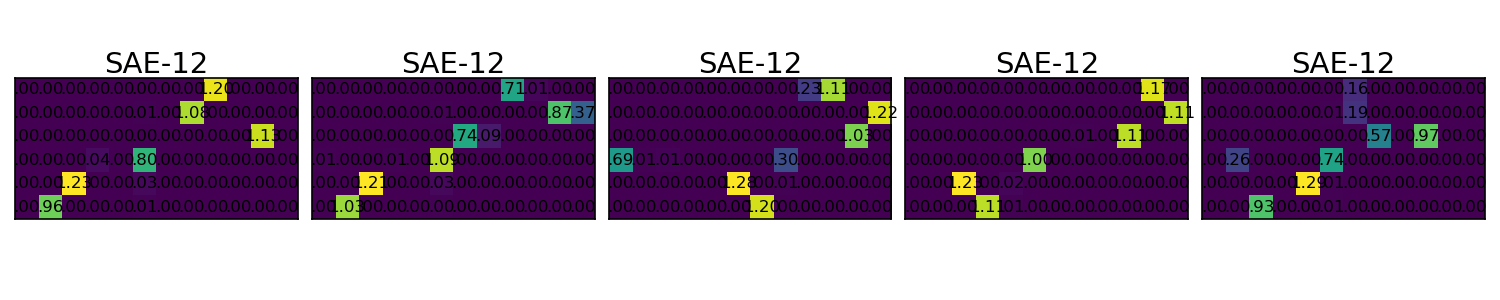

Figure seeds_AE-S12_FactorResponse_matrices saved as {'png', 'pdf'}


In [209]:
fg, axes = plt.subplots(H,W, figsize=(10,3) if mat_name == 'Response' else (10,2))
axes = axes.reshape(-1)

content = allMats[mat_name]

for ax, mat in zip(axes, content):
    plt.sca(ax)
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(mat, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(info.group_names[groups[model]], pad=-1)

    
# for i in range(len(allRs), nax):
#     axes[i].axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.05, bottom=0.04, top=0.97, left=0.01, right=0.99)
modelname = model.replace(' ','-')
util.save_figure(f'seeds_{modelname}_{mat_name}_matrices', **save_figure_kwargs)

In [ ]:
factor_order =  ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
factors = {'floor_hue': 'Floor Hue', 'wall_hue': 'Wall Hue', 'object_hue': 'Object Hue', 'scale': 'Scale', 'shape': 'Shape', 'orientation': 'Orientation'}


In [ ]:
fg, axes = plt.subplots(H,W, figsize=(15,10) if mat_name == 'Response' else (15,5.5))
axes = axes.reshape(-1)

for ax, title in zip(axes, title_order):
    plt.sca(ax)
    
    Rs = allRs[title]
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(Rs, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(run_idents[title].title, pad=-1)

    
for i in range(len(allRs), nax):
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.15, wspace=0.02, bottom=0.04, top=0.97, left=0.01, right=0.99)
util.save_figure(f'{dscode}_{mat_name}_matrices', **save_figure_kwargs)

In [ ]:
M, F, R = run.data['Response'], run.data['FactorResponse'].min(1)[0].max(-1)[0], run.data['DCI'].T
M.shape, F.shape, R.shape